# Variant exploration
We've used the `nf-core/sarek` pipeline to call variants in our samples; now let's explore the data we have!

In [1]:
from pysam import VariantFile
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Read in the data
`0M_R1` was grown without EMS in 10/10

`0_1M_R1` was treated with EMS in 10/10

In [2]:
vcf_0M_R1 = VariantFile('../data/nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2.strelka.somatic_snvs.vcf.gz') 
vcf_0_1M_R2 = VariantFile('../data/nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2.strelka.somatic_snvs.vcf.gz') 

In [3]:
all_variants_0M_R1 = vcf_0M_R1.fetch()
all_variants_0_1M_R2 = vcf_0_1M_R2.fetch()

## Filtering by support
As mentioned in [this video](https://youtu.be/zO9WCOaq3aQ?si=GZD3t4__wenFgTxh&t=665), variants that only appear in a few reads are more likely to be sequencing errors than true variants. Therefore, we want to filter our variants. While Strelka2 doesn't provide a score in the `QUAL` column of the `vcf` file, it does provide a `PASS` value based on the Empirical Variant Scoring model (see [Supplementary Note 1](https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-018-0051-x/MediaObjects/41592_2018_51_MOESM1_ESM.pdf)) if the variant is good quality, or `LowEVS` or `LowDepth` if it's not a good variant.

In [4]:
all_alts = {}
all_conversions = {}
all_passed = {}
for sample, variants in {'0M_R1': all_variants_0M_R1, '0_1M_R2': all_variants_0_1M_R2}.items():
    passed = []
    alts = defaultdict(int)
    conversions = defaultdict(int)
    total = 0
    for variant in variants:
        if variant.filter.keys()[0] == 'PASS':
            # print(variant.chrom, variant.pos, variant.ref, ">", variant.alts[0], variant.qual, variant.filter.values()[0].name)
            passed.append(variant)
            alts[variant.alts[0]] += 1
            conversions[f'{variant.ref} > {variant.alts[0]}'] += 1
        total += 1
    print(f'For sample {sample}, {len(passed)} of {total} variants passed, which is {(len(passed)/total)*100:.2f}%.')
    all_alts[sample] = alts
    all_conversions[sample] = conversions
    all_passed[sample] = passed

For sample 0M_R1, 51 of 41470 variants passed, which is 0.12%.
For sample 0_1M_R2, 556 of 46391 variants passed, which is 1.20%.


That's great! It substantially narrows down our analysis. Let's save out the filtered subset to look at in IGV:

In [5]:
# Adapted from the Gemini suggested answer
for sample in ['0M_R1', '0_1M_R2']:
    with VariantFile(f'../data/nanno_sarek/variant_calling/strelka/{sample}_vs_537_control_R2/{sample}_vs_537_control_R2.strelka.somatic_snvs.vcf.gz') as vcf_in, \
         VariantFile(f'../data/nanno_sarek/variant_calling/strelka/{sample}_vs_537_control_R2/{sample}_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz', 'w', header=vcf_in.header) as vcf_out:
    
        for record in vcf_in:
            if 'PASS' in record.filter.keys():
                vcf_out.write(record)

## Digging into SNVs
Let's take a look at the landscape of variants quantitatively, beyond just looking at the viewer. First, let's look at the rates of the different transitions (which I'll calculate here as just the fraction of times the transition occurred of the variants that passed the screening -- I think this is different than the calculations done in the Arabidopsis paper linked below). Does this match with published expectations of the rates of these transitions?

We'll pair together transitions that are complements of one another, as was done in [Ossowski et al, 2014, Table 2](https://pmc.ncbi.nlm.nih.gov/articles/PMC3878865/table/T2/):
```
A:T→G:C
C:G→T:A
A:T→T:A
C:G→A:T
A:T→C:G
C:G→G:C
```

In [6]:
conversion_pairs = {
    'A:T→G:C': ['A > G', 'T > C'],
    'C:G→T:A': ['C > T', 'G > A'],
    'A:T→T:A': ['A > T', 'T > A'],
    'C:G→A:T': ['C > A', 'G > T'],
    'A:T→C:G': ['A > C', 'T > G'],
    'C:G→G:C': ['C > G', 'G > C']
}

In [7]:
conversion_probs = defaultdict(dict)
for sample, conversions in all_conversions.items():
    for name, pair in conversion_pairs.items():
        pair_total = conversions[pair[0]] + conversions[pair[1]]
        conversion_probs[sample][name] = pair_total/len(all_passed[sample])

In [8]:
# Need tow rangle for stacked bars
conversions_to_plot = {pair: np.array([v[pair] for v in conversion_probs.values()]) for pair in conversion_pairs.keys()}

In [9]:
conversions_to_plot

{'A:T→G:C': array([0.23529412, 0.03956835]),
 'C:G→T:A': array([0.09803922, 0.86330935]),
 'A:T→T:A': array([0.07843137, 0.02517986]),
 'C:G→A:T': array([0.19607843, 0.02697842]),
 'A:T→C:G': array([0.21568627, 0.02158273]),
 'C:G→G:C': array([0.17647059, 0.02338129])}

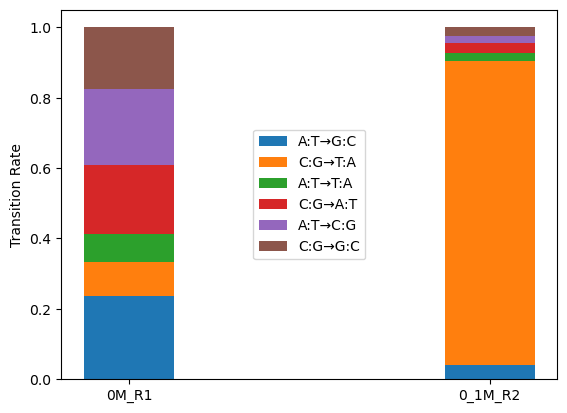

In [10]:
fig, ax = plt.subplots()

width = 0.25
bottom = np.zeros(2)

for name, probs in conversions_to_plot.items():
    ax.bar(conversion_probs.keys(), probs, width, bottom=bottom, label=f'{name}')
    bottom += probs

ax.set_ylabel('Transition Rate')
ax.legend(loc='center')

plt.show()

This is quite cool -- EMS is [known to induce mainly C:G→T:A mutations](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2022.1052569/full), and we see an enormous rate increase of that kind of mutation in the EMS sample vs. the one that was allowed to evolve on its own.

## Indels
Thus far we've only looked at the SNVs in our data; what about the indels?

In [2]:
vcf_0M_R1_indels = VariantFile('../data/nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2.strelka.somatic_indels.vcf.gz') 
vcf_0_1M_R2_indels = VariantFile('../data/nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2.strelka.somatic_indels.vcf.gz') 

In [3]:
indels_variants_0M_R1 = vcf_0M_R1_indels.fetch()
indels_variants_0_1M_R2 = vcf_0_1M_R2_indels.fetch()

In [4]:
for sample, variants in {'0M_R1': indels_variants_0M_R1, '0_1M_R2': indels_variants_0_1M_R2}.items():
    print(f'Indel variants for sample {sample}:')
    print('-------------------------------------------')
    passed = []
    total = 0
    for variant in variants:
        if variant.filter.keys()[0] == 'PASS':
            print(variant.chrom, variant.pos, variant.ref, ">", variant.alts[0], variant.qual, variant.filter.values()[0].name)
            passed.append(variant)
        total += 1
    print(f'\nFor sample {sample}, {len(passed)} of {total} variants passed, which is {(len(passed)/total)*100:.2f}%.\n')

Indel variants for sample 0M_R1:
-------------------------------------------
scf_2 453749 AC > A None PASS
scf_9 1044578 C > CAATA None PASS
scf_11 803969 T > TCGACGG None PASS
scf_14 38344 CA > C None PASS
scf_17 66764 C > CCCTT None PASS
scf_19 567213 A > AAT None PASS
scf_19 572560 CT > C None PASS
scf_21 107074 CCT > C None PASS
scf_21 196997 GTGTTCA > G None PASS
scf_21 197209 GT > G None PASS
scf_21 197734 GC > G None PASS
scf_29 211683 C > CAT None PASS
scf_35 48363 GTA > G None PASS
scf_36 103574 TC > T None PASS

For sample 0M_R1, 14 of 422 variants passed, which is 3.32%.

Indel variants for sample 0_1M_R2:
-------------------------------------------
scf_6 712028 GCGC > G None PASS
scf_14 627792 C > CCCCTCTCT None PASS
scf_16 149718 A > AAT None PASS
scf_19 707589 T > TC None PASS
scf_20 158358 A > AG None PASS
scf_24 819444 TG > T None PASS
scf_24 1002851 TCTGGAA > T None PASS
scf_29 211683 CAT > C None PASS
scf_32 550041 C > CG None PASS

For sample 0_1M_R2, 9 of 428 varian

There are way fewer indel mutants than point mutations, and a similar number between the normal and EMS mutants, which makes sense, as EMS induces point mutations. Write them out:

In [5]:
# Adapted from the Gemini suggested answer
for sample in ['0M_R1', '0_1M_R2']:
    with VariantFile(f'../data/nanno_sarek/variant_calling/strelka/{sample}_vs_537_control_R2/{sample}_vs_537_control_R2.strelka.somatic_indels.vcf.gz') as vcf_in, \
         VariantFile(f'../data/nanno_sarek/variant_calling/strelka/{sample}_vs_537_control_R2/{sample}_vs_537_control_R2_FILTERED.strelka.somatic_indels.vcf.gz', 'w', header=vcf_in.header) as vcf_out:
    
        for record in vcf_in:
            if 'PASS' in record.filter.keys():
                vcf_out.write(record)

## Investigating mutations
We now want to narrow in on what genes these mutations may be impacting. Ideally, we want to see what genes are affected by the SNPs and indels. A useful tool for this is the [BEDtools](https://bedtools.readthedocs.io/en/latest/) module; specifically, we can [get the intersection of a SNP file with a genome annotation](https://www.biostars.org/p/379113/#379121). The bulk of this work will take place on the command line.

First, we need to convert the `gff3` annotation file to a `gtf` file with `gffread`. From within the `data/genome` directory:

```
gffread n_salina.working_models.gff3 -T -o n_salina.working_models.gtf
```
(Note: I provided the full path to where I'd cloned `gffread` rather than adding to `PATH`)

Next, use BEDtools to get the intersections. I'm going to start with the non-EMS sample SNV's to get a handle on how the results will look:
```
bedtools intersect -wa -wb -a ../nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz -b n_salina.working_models.gtf > ../nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED_SNVs_overlap_with_annotations.txt
```

In [14]:
gene_intersects_0M_R1 = pd.read_csv('../data/nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED_SNVs_overlap_with_annotations.txt', sep='\t', header=None)
gene_intersects_0M_R1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,scf_1,167764,.,T,G,.,PASS,SOMATIC;QSS=48;TQSS=1;NT=ref;QSS_NT=48;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"163:0:0:0:3,3:4,4:3,3:153,154","200:2:0:0:4,5:8,8:9,9:177,178",scf_1,MSU_v1,transcript,167216,168580,.,-,.,"transcript_id ""N_sal.S000450.1""; gene_id ""N_sa..."
1,scf_1,167764,.,T,G,.,PASS,SOMATIC;QSS=48;TQSS=1;NT=ref;QSS_NT=48;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"163:0:0:0:3,3:4,4:3,3:153,154","200:2:0:0:4,5:8,8:9,9:177,178",scf_1,MSU_v1,exon,167216,168580,.,-,.,"transcript_id ""N_sal.S000450.1""; gene_id ""N_sa..."
2,scf_1,167764,.,T,G,.,PASS,SOMATIC;QSS=48;TQSS=1;NT=ref;QSS_NT=48;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"163:0:0:0:3,3:4,4:3,3:153,154","200:2:0:0:4,5:8,8:9,9:177,178",scf_1,MSU_v1,CDS,167216,168580,.,-,0,"transcript_id ""N_sal.S000450.1""; gene_id ""N_sa..."
3,scf_1,860759,.,C,A,.,PASS,SOMATIC;QSS=91;TQSS=1;NT=ref;QSS_NT=91;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"150:0:0:0:3,3:147,148:0,0:0,0","231:1:0:0:52,53:178,181:0,0:0,0",scf_1,MSU_v1,transcript,860486,862164,.,+,.,"transcript_id ""N_sal.S002930.1""; gene_id ""N_sa..."
4,scf_1,947966,.,G,C,.,PASS,SOMATIC;QSS=62;TQSS=1;NT=ref;QSS_NT=62;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"131:1:0:0:1,1:1,1:128,130:0,0","154:1:0:0:1,2:14,14:135,137:3,3",scf_1,MSU_v1,transcript,945949,952185,.,-,.,"transcript_id ""N_sal.S003280.1""; gene_id ""N_sa..."


Columns 0-10 are the SNVs data, while 11-19 are from the genome annotation. What we really want is the gene name from the last column for each SNV:

In [15]:
gene_intersects_0M_R1['gene_name'] = gene_intersects_0M_R1[19].str.split('"').str[1]

For now, we'll only keep the CDS objects:

In [16]:
gene_intersects_0M_R1 = gene_intersects_0M_R1[gene_intersects_0M_R1[13] == 'CDS'].reset_index(drop=True)

How many SNV-affected genes do we have in the non-EMS mutant?

In [17]:
gene_intersects_0M_R1.groupby(by='gene_name').count().shape[0]

40

Only 40! Now let's see how many of those genes overlap with SNV-affected genes in the EMS mutant; we'll do the command line step for BEDtools intersect again with that file:

```
bedtools intersect -wa -wb -a ../nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED.strelka.somatic_snvs.vcf.gz -b n_salina.working_models.gtf > ../nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED_SNVs_overlap_with_annotations.txt
```

In [18]:
gene_intersects_0_1M_R2 = pd.read_csv('../data/nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED_SNVs_overlap_with_annotations.txt', sep='\t', header=None)
gene_intersects_0_1M_R2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,scf_1,101592,.,C,T,.,PASS,SOMATIC;QSS=97;TQSS=2;NT=ref;QSS_NT=97;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"111:4:0:0:0,0:107,115:0,2:0,0","151:8:0:0:0,1:125,137:0,2:18,18",scf_1,MSU_v1,transcript,101442,104482,.,+,.,"transcript_id ""N_sal.S000260.1""; gene_id ""N_sa..."
1,scf_1,101592,.,C,T,.,PASS,SOMATIC;QSS=97;TQSS=2;NT=ref;QSS_NT=97;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"111:4:0:0:0,0:107,115:0,2:0,0","151:8:0:0:0,1:125,137:0,2:18,18",scf_1,MSU_v1,exon,101442,102074,.,+,.,"transcript_id ""N_sal.S000260.1""; gene_id ""N_sa..."
2,scf_1,170428,.,C,T,.,PASS,SOMATIC;QSS=74;TQSS=1;NT=ref;QSS_NT=74;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"91:8:0:0:0,0:83,93:0,0:0,0","121:18:0:0:0,0:96,114:0,0:7,7",scf_1,MSU_v1,transcript,169388,171263,.,+,.,"transcript_id ""N_sal.S000460.1""; gene_id ""N_sa..."
3,scf_1,286810,.,G,A,.,PASS,SOMATIC;QSS=44;TQSS=2;NT=ref;QSS_NT=44;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"201:0:0:0:1,1:0,0:200,200:0,0","205:1:0:0:5,5:0,0:199,201:0,0",scf_1,MSU_v1,transcript,286705,287415,.,+,.,"transcript_id ""N_sal.S000920.1""; gene_id ""N_sa..."
4,scf_1,286810,.,G,A,.,PASS,SOMATIC;QSS=44;TQSS=2;NT=ref;QSS_NT=44;TQSS_NT...,DP:FDP:SDP:SUBDP:AU:CU:GU:TU,"201:0:0:0:1,1:0,0:200,200:0,0","205:1:0:0:5,5:0,0:199,201:0,0",scf_1,MSU_v1,exon,286705,287415,.,+,.,"transcript_id ""N_sal.S000920.1""; gene_id ""N_sa..."


In [19]:
gene_intersects_0_1M_R2['gene_name'] = gene_intersects_0_1M_R2[19].str.split('"').str[1]
gene_intersects_0_1M_R2 = gene_intersects_0_1M_R2[gene_intersects_0_1M_R2[13] == 'CDS'].reset_index(drop=True)

In [20]:
gene_intersects_0_1M_R2.groupby(by='gene_name').count().shape[0]

345

In [21]:
ems_genes = gene_intersects_0_1M_R2.groupby(by='gene_name').count().index.tolist()
normal_genes = gene_intersects_0M_R1.groupby(by='gene_name').count().index.tolist()

In [22]:
overlapping_snps = set(ems_genes).intersection(set(normal_genes))
overlapping_snps

{'N_sal.S003280.1', 'N_sal.S084590.1', 'N_sal.S088740.1'}

Only 3 genes overlap between the two conditions!

Now let's look at which indels appear in coding regions:

```
bedtools intersect -wa -wb -a ../nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED.strelka.somatic_indels.vcf.gz -b n_salina.working_models.gtf > ../nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED_indels_overlap_with_annotations.txt

bedtools intersect -wa -wb -a ../nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED.strelka.somatic_indels.vcf.gz -b n_salina.working_models.gtf > ../nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED_indels_overlap_with_annotations.txt
```

In [8]:
indel_intersects_0M_R1 = pd.read_csv('../data/nanno_sarek/variant_calling/strelka/0M_R1_vs_537_control_R2/0M_R1_vs_537_control_R2_FILTERED_indels_overlap_with_annotations.txt', sep='\t', header=None)
indel_intersects_0M_R1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,scf_2,453749,.,AC,A,.,PASS,SOMATIC;QSI=66;TQSI=1;NT=ref;QSI_NT=66;TQSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"118:118:103,116:3,3:13,1:118.96:7.27:0:0.06","121:121:72,83:23,26:25,13:116.66:6.6:0:0.05",scf_2,MSU_v1,transcript,452792,455413,.,-,.,"transcript_id ""N_sal.S016490.1""; gene_id ""N_sa..."
1,scf_11,803969,.,T,TCGACGG,.,PASS,SOMATIC;QSI=109;TQSI=1;NT=ref;QSI_NT=109;TQSI_...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"125:125:119,119:0,0:4,4:137.93:0.01:0:0","192:192:142,143:30,30:18,18:181.19:0.56:0:0",scf_11,MSU_v1,transcript,803966,806674,.,-,.,"transcript_id ""N_sal.S061470.1""; gene_id ""N_sa..."
2,scf_11,803969,.,T,TCGACGG,.,PASS,SOMATIC;QSI=109;TQSI=1;NT=ref;QSI_NT=109;TQSI_...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"125:125:119,119:0,0:4,4:137.93:0.01:0:0","192:192:142,143:30,30:18,18:181.19:0.56:0:0",scf_11,MSU_v1,exon,803966,804529,.,-,.,"transcript_id ""N_sal.S061470.1""; gene_id ""N_sa..."
3,scf_11,803969,.,T,TCGACGG,.,PASS,SOMATIC;QSI=109;TQSI=1;NT=ref;QSI_NT=109;TQSI_...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"125:125:119,119:0,0:4,4:137.93:0.01:0:0","192:192:142,143:30,30:18,18:181.19:0.56:0:0",scf_11,MSU_v1,CDS,803966,804529,.,-,0,"transcript_id ""N_sal.S061470.1""; gene_id ""N_sa..."
4,scf_17,66764,.,C,CCCTT,.,PASS,SOMATIC;QSI=95;TQSI=2;NT=ref;QSI_NT=95;TQSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"98:98:87,91:2,5:14,8:95.48:11.66:0:0.12","82:82:50,52:26,28:10,7:77.84:7.28:0:0.09",scf_17,MSU_v1,transcript,63757,70998,.,+,.,"transcript_id ""N_sal.S064940.1""; gene_id ""N_sa..."


In [9]:
indel_intersects_0M_R1['gene_name'] = indel_intersects_0M_R1[19].str.split('"').str[1]
indel_intersects_0M_R1 = indel_intersects_0M_R1[indel_intersects_0M_R1[13] == 'CDS'].reset_index(drop=True)
indel_intersects_0M_R1.groupby(by='gene_name').count().shape[0]

2

In [10]:
indel_intersects_0_1M_R2 = pd.read_csv('../data/nanno_sarek/variant_calling/strelka/0_1M_R2_vs_537_control_R2/0_1M_R2_vs_537_control_R2_FILTERED_indels_overlap_with_annotations.txt', sep='\t', header=None)
indel_intersects_0_1M_R2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,scf_14,627792,.,C,CCCCTCTCT,.,PASS,SOMATIC;QSI=153;TQSI=1;NT=ref;QSI_NT=154;TQSI_...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"109:109:107,107:0,0:2,2:108.73:5.09:0:0.05","96:96:62,65:31,32:3,3:93.88:5.66:0:0.05",scf_14,MSU_v1,transcript,625605,629168,.,-,.,"transcript_id ""N_sal.S080730.1""; gene_id ""N_sa..."
1,scf_16,149718,.,A,AAT,.,PASS,SOMATIC;QSI=48;TQSI=1;NT=ref;QSI_NT=48;TQSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"30:30:24,24:0,0:4,5:39.61:0.27:0:0","28:28:22,23:4,4:2,2:36.04:0.47:0:0",scf_16,MSU_v1,transcript,147799,151161,.,-,.,"transcript_id ""N_sal.S073150.2""; gene_id ""N_sa..."
2,scf_16,149718,.,A,AAT,.,PASS,SOMATIC;QSI=48;TQSI=1;NT=ref;QSI_NT=48;TQSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"30:30:24,24:0,0:4,5:39.61:0.27:0:0","28:28:22,23:4,4:2,2:36.04:0.47:0:0",scf_16,MSU_v1,transcript,147799,151367,.,-,.,"transcript_id ""N_sal.S073150.1""; gene_id ""N_sa..."
3,scf_16,149718,.,A,AAT,.,PASS,SOMATIC;QSI=48;TQSI=1;NT=ref;QSI_NT=48;TQSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"30:30:24,24:0,0:4,5:39.61:0.27:0:0","28:28:22,23:4,4:2,2:36.04:0.47:0:0",scf_16,MSU_v1,transcript,147813,151295,.,-,.,"transcript_id ""N_sal.S073150.3""; gene_id ""N_sa..."
4,scf_20,158358,.,A,AG,.,PASS,SOMATIC;QSI=38;TQSI=1;NT=ref;QSI_NT=38;TQSI_NT...,DP:DP2:TAR:TIR:TOR:DP50:FDP50:SUBDP50:BCN50,"36:36:35,39:0,0:1,1:34.41:2.26:0:0.06","57:57:47,48:6,6:4,6:51.67:1.93:0:0.02",scf_20,MSU_v1,transcript,152063,162621,.,-,.,"transcript_id ""N_sal.S050720.1""; gene_id ""N_sa..."


In [11]:
indel_intersects_0_1M_R2['gene_name'] = indel_intersects_0_1M_R2[19].str.split('"').str[1]
indel_intersects_0_1M_R2 = indel_intersects_0_1M_R2[indel_intersects_0_1M_R2[13] == 'CDS'].reset_index(drop=True)
indel_intersects_0_1M_R2.groupby(by='gene_name').count().shape[0]

1

Only 3 indels overlap coding regions -- what genes are they?

In [25]:
indel_genes_0M_R1 = indel_intersects_0M_R1.groupby(by='gene_name').count().index.tolist()
indel_genes_0_1M_R2 = indel_intersects_0_1M_R2.groupby(by='gene_name').count().index.tolist()
indel_genes_0M_R1, indel_genes_0_1M_R2

(['N_sal.S061470.1', 'N_sal.S084590.1'], ['N_sal.S034610.1'])

None of them overlap between the two mutation conditions:

In [24]:
overlapping_indels = set(indel_genes_0M_R1).intersection(set(indel_genes_0_1M_R2))
overlapping_indels

set()

Do any of them appear in genes that also have SNPs?

In [26]:
set(indel_genes_0M_R1).intersection(set(normal_genes))

{'N_sal.S084590.1'}

In [27]:
set(indel_genes_0_1M_R2).intersection(set(ems_genes))

set()